<a href="https://colab.research.google.com/github/tchintchie/whgscraper/blob/master/soup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [292]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [169]:
def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error(f'Error during requests to {url} : {str(e)}')
        return None

In [170]:

def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)

In [171]:

def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)

In [180]:
url = "https://www.oehboersen.at"
html = simple_get(url)

In [181]:
oeh = bs(html, "html5lib")

In [182]:
title = oeh.title.string

In [183]:
rows = oeh.find_all("div", class_="property-content")
rows[0]

<div class="property-content">
		
				<div class="row visible-xs visible-sm">
			<span class="type">2-Zimmer Wohnung</span> <span>·</span> <span class="status">Miete</span>		</div>
		
		<div class="row headlines">
			<a href="https://www.oehboersen.at/property/2-zimmer-wohnung-ueber-den-daechern-der-stadt/" tabindex="0"><h3 class="title col-sm-8">2.Zimmer.Wohnung.Über den Dächern der Stadt</h3> </a>
			<div class="price-tag col-sm-4"><h4 class="price text-primary">€ 597,- <span class="BKInfo">(inkl. BK)</span></h4>
								<h4 class="flaeche">63 m<sup>2</sup></h4>
							</div>
		</div>
		
				
		<div class="row">
			<a href="https://www.oehboersen.at/property/2-zimmer-wohnung-ueber-den-daechern-der-stadt/"><h4 class="address col-sm-8"><strong>Altstadt</strong><br/><br/></h4></a>
			
		</div>
		

			
				<div class="property-meta clearfix">
							<div>
					<div class="meta-title"><i class="fa fa-expand"></i></div>
					<div class="meta-data" data-toggle="tooltip" title="Fläche des Mi

In [249]:
p = oeh.find("ul",class_="page-numbers")
end = int([li.text for li in p("li")][-2])

In [250]:
def scrape_pages():

  titles = []
  types = []
  prices = []
  bks = []
  areas = []
  
  for i in range(1,end+1):
    url = "https://www.oehboersen.at/page/0"
    html = simple_get(url)
    oeh = bs(html, "html.parser")
    for div in oeh.find_all("div",class_ = "property-content"):
      title = div.find("h3",class_="title col-sm-8").text
      titles.append(title)
      type_ = div.find("span", class_="type").text
      types.append(type_)
      price=div.find("h4",class_= "price text-primary").next
      prices.append(price)
      bk= div.find("span", class_="BKInfo").text
      bks.append(bk)
      if div.find("div", attrs={"title":"Fläche des Mietgegenstandes"}) != None:
        area = div.find("div", attrs={"title":"Fläche des Mietgegenstandes"}).text
      else:
        area = "NA"
      areas.append(area)
    titles_s = pd.Series(titles, name="title")
    types_s = pd.Series(types, name = "type")
    prices_s = pd.Series(prices, name="price")
    bks_s = pd.Series(bks, name = "bk")
    areas_s = pd.Series(areas, name = "area")  
  return pd.concat([titles_s, types_s, prices_s, bks_s, areas_s], axis = 1)

In [251]:
all_content = scrape_pages()

In [252]:
all_content

,title,type,price,bk,area
0,2.Zimmer.Wohnung.Über den Dächern der Stadt,2-Zimmer Wohnung,"€ 597,-",(inkl. BK),63 m2
1,Gemütliche Bleibe in Sportlicher 3er WG,Zimmer in 3er WG,"€ 280,-",(inkl. BK),8 m2
2,Roomie in 5er WG,Zimmer in 5er WG,"€ 430,-",(inkl. BK),13.5 m2
3,Schöne 3 Zimmerwohnung in Pradl als 3er WG an ...,3-Zimmer Wohnung,"€ 1200,-",(inkl. BK),64 m2
4,"Zwischenmiete August+September, 22qm Zimmer im...",Zimmer in 3er WG,"€ 440,-",(inkl. BK),NA
...,...,...,...,...,...
205,Schöne 2 Zimmerwohnung mit Garten in Innsbruck...,2-Zimmer Wohnung,"€ 550,-",(inkl. BK),70 m2
206,ZENTRALER PARKPLATZ zu vermieten!,Autoabstellplatz,"€ 100,-",(inkl. BK),NA
207,"Sonnige 3-Zimmer-Wohnung in Kematen, WG-tauglich",3-Zimmer Wohnung,"€ 1000,-",(inkl. BK),79.09 m2
208,20 m² Zimmer in 3er WG nahe Westbahnhof (Wilte...,Zimmer in 3er WG,"€ 435,-",(inkl. BK),20 m2


In [253]:
all_content["type"].value_counts()

Zimmer in 3er WG    50
Autoabstellplatz    30
2-Zimmer Wohnung    30
Zimmer in 2er WG    30
3-Zimmer Wohnung    30
Zimmer in 5er WG    10
Wohnung             10
Garçonnière         10
Zimmer in WG        10
Name: type, dtype: int64

In [254]:
all_content.bk.value_counts()

(inkl. BK)    210
Name: bk, dtype: int64

In [265]:
all_content["price"] = all_content.price.str.replace("€","").str.strip().str.replace(",-","").str.replace(",",".").str.strip().astype("float")

In [278]:
all_content["area"] = all_content.area.str.replace("m2","").str.replace("NA", "0").str.strip().astype("float")

In [281]:
all_content["type"] = all_content["type"].astype("category")

In [284]:
all_content["type"].cat.categories

Index(['2-Zimmer Wohnung', '3-Zimmer Wohnung', 'Autoabstellplatz',
       'Garçonnière', 'Wohnung', 'Zimmer in 2er WG', 'Zimmer in 3er WG',
       'Zimmer in 5er WG', 'Zimmer in WG'],
      dtype='object')

In [285]:
no_wg = all_content.copy()
no_wg["type"] = no_wg["type"].cat.remove_categories(['Autoabstellplatz','Zimmer in 2er WG', 'Zimmer in 3er WG','Zimmer in 5er WG', 'Zimmer in WG'])
no_wg.head()

,title,type,price,bk,area
0,2.Zimmer.Wohnung.Über den Dächern der Stadt,2-Zimmer Wohnung,597.0,(inkl. BK),63.0
1,Gemütliche Bleibe in Sportlicher 3er WG,NaN,280.0,(inkl. BK),8.0
2,Roomie in 5er WG,NaN,430.0,(inkl. BK),13.5
3,Schöne 3 Zimmerwohnung in Pradl als 3er WG an ...,3-Zimmer Wohnung,1200.0,(inkl. BK),64.0
4,"Zwischenmiete August+September, 22qm Zimmer im...",NaN,440.0,(inkl. BK),0.0


In [286]:
no_wg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   title   210 non-null    object  
 1   type    80 non-null     category
 2   price   210 non-null    float64 
 3   bk      210 non-null    object  
 4   area    210 non-null    float64 
dtypes: category(1), float64(2), object(2)
memory usage: 7.1+ KB


In [288]:
no_wg.dropna(axis = 0, inplace=True)

In [289]:
no_wg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 207
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   title   80 non-null     object  
 1   type    80 non-null     category
 2   price   80 non-null     float64 
 3   bk      80 non-null     object  
 4   area    80 non-null     float64 
dtypes: category(1), float64(2), object(2)
memory usage: 3.4+ KB


In [291]:
no_wg.describe()

,price,area
count,80.000000,80.00000
mean,868.375000,56.01125
std,264.122113,19.11374
min,550.000000,17.00000
25%,599.250000,50.00000
50%,860.000000,63.50000
75%,1110.000000,66.25000
max,1200.000000,79.09000


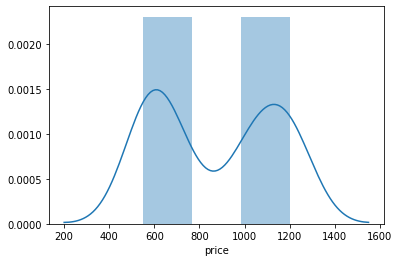

In [297]:
sns.distplot(no_wg.price)
plt.show()

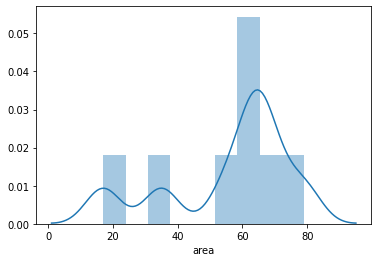

In [298]:
sns.distplot(no_wg.area)
plt.show()

In [299]:
groups = no_wg.groupby(by="type").mean()

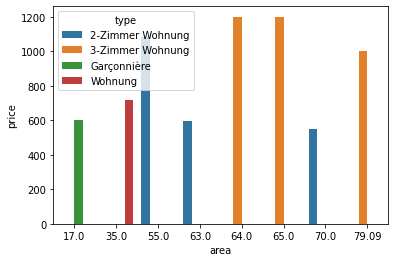

In [306]:
sns.barplot(x = no_wg.area, y = no_wg.price, hue = no_wg["type"])
plt.show()